<a href="https://colab.research.google.com/github/JimKing100/DS-Unit-2-Applied-Modeling/blob/master/Curry_Study_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [93]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install pandas-profiling==2.3.0
    !pip install plotly==4.1.1

In [94]:
# Imports
import os, sys

os.chdir('/content')
!git init .
!git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
!git pull origin master

!pip install -r requirements.txt

os.chdir('module1')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [96]:
# Read data
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [97]:
# Check for nulls
df.isnull().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
game_date                  0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [98]:
# Baseline mean of made shots
df['shot_made_flag'].mean()

0.4729187562688064

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [99]:
# Train, test split on date of 10/1/2018
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2018-10-01')
train = df[df['game_date'] < cutoff]
test  = df[df['game_date'] >= cutoff]

print(train.shape)
print(test.shape)

(12249, 20)
(1709, 20)


## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

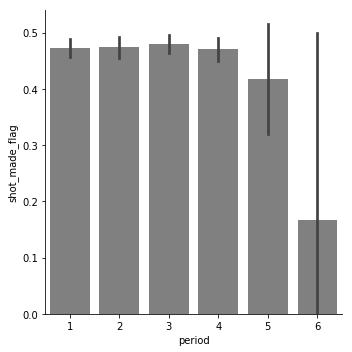

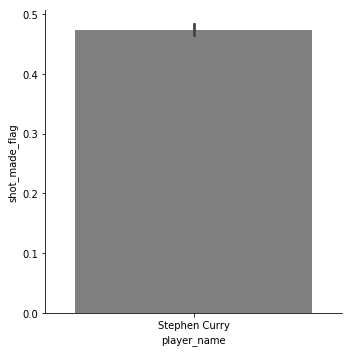

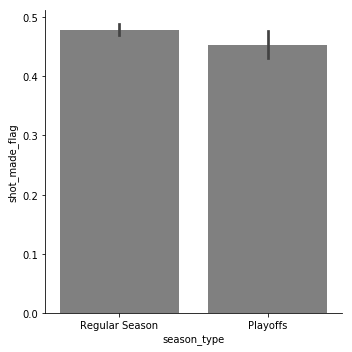

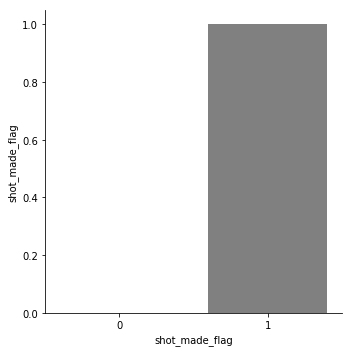

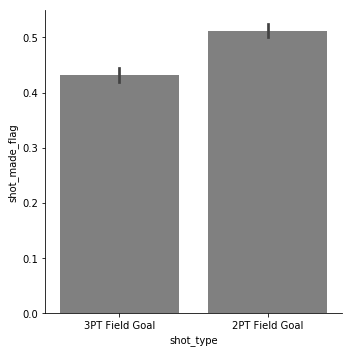

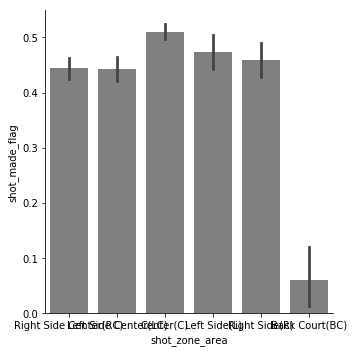

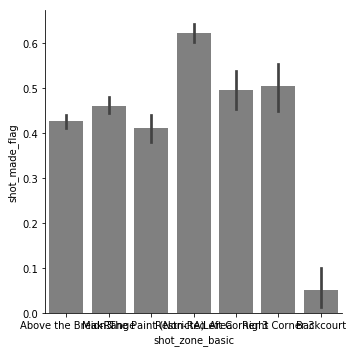

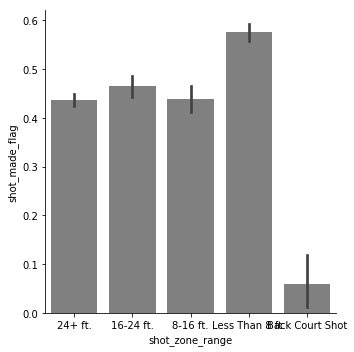

In [100]:
# Explore features
for col in sorted(train.columns):
    if train[col].nunique() < 12:
        sns.catplot(x=col, y='shot_made_flag', data = train, kind = 'bar', color = 'grey')
        plt.show()

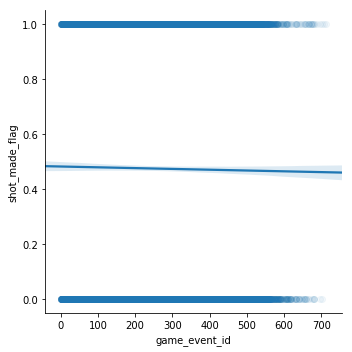

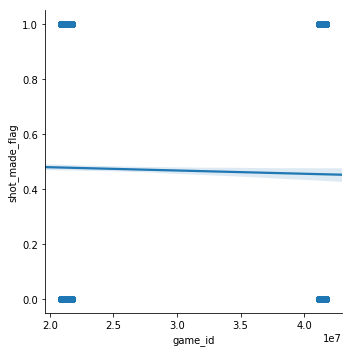

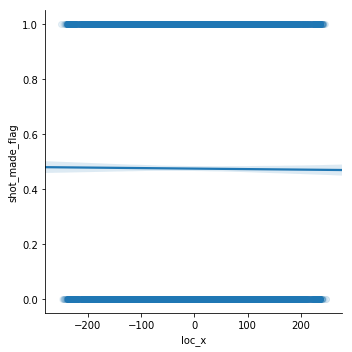

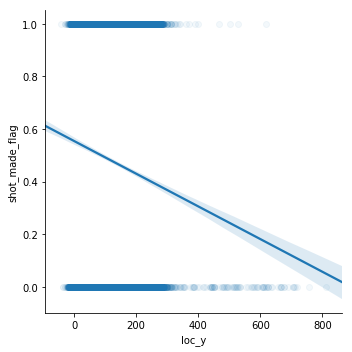

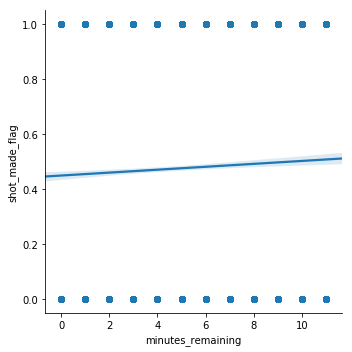

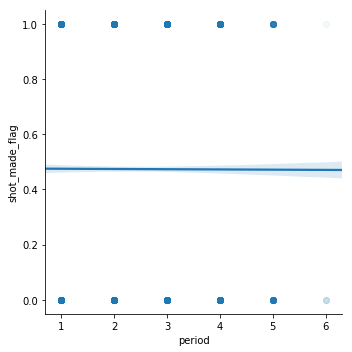

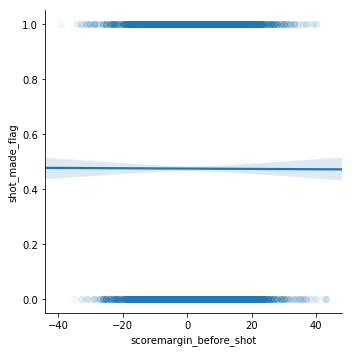

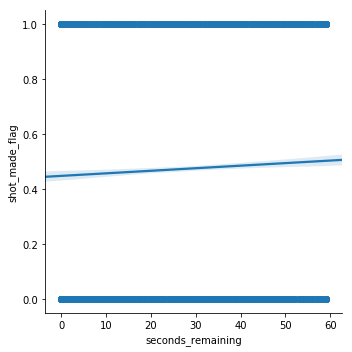

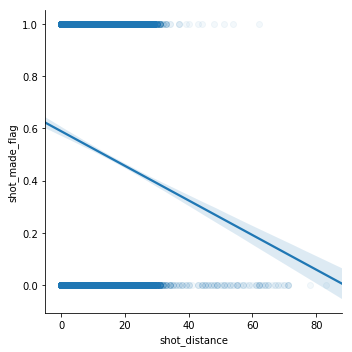

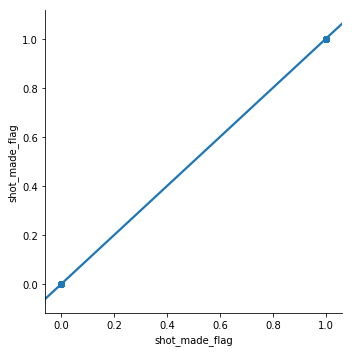

In [101]:
# Explore features
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y = 'shot_made_flag', data = train, scatter_kws = dict(alpha=0.05))
    plt.show()

In [102]:
# Wrangle the data for train and test
def engineer_features(X):
  
  # Convert date_recorded to datetime
  X['game_date'] = pd.to_datetime(X['game_date'], infer_datetime_format=True)
    
  # Extract components from date_recorded and drop the original column
  X['year_game'] = X['game_date'].dt.year
  X['month_game'] = X['game_date'].dt.month
  X['day_game'] = X['game_date'].dt.day
  X = X.drop(columns='game_date')
  
  def home(hteam):
    if hteam == 'GSW':
      result = True
    else: 
      result = False
    return result
  
  def opp(hteam, vteam):
    if hteam == 'GSW':
      result = vteam
    else: 
      result = hteam
    return result
    
  X['home_court'] = X.apply(lambda x: home(x['htm']), axis=1)  
  X['opponent'] =   X.apply(lambda x: opp(x['htm'], x['vtm']), axis=1)  
  X['period_seconds'] = (X['minutes_remaining'] * 60) + X['seconds_remaining']
  X['distance_time'] = X['period_seconds'] * X['shot_distance']
  
  return X

train = engineer_features(train)
test = engineer_features(test)

print(train.shape)
train.head()

(12249, 26)


,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,year_game,month_game,day_game,home_court,opponent,period_seconds,distance_time
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0,2009,10,28,True,HOU,685,17810
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0,2009,10,28,True,HOU,571,10278
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0,2009,10,28,True,HOU,362,5068
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0,2009,10,28,True,HOU,589,11191
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0,2009,10,28,True,HOU,139,2224


## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [103]:
# Split training data into training and validation sets 80/20 
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)
print(train.shape, val.shape, test.shape)

(9799, 26) (2450, 26) (1709, 26)


## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
# Encode and fit a Random Forest Model - Optimization done at end and value used here
target = 'shot_made_flag'
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=200, 
                             random_state=42,
                             min_samples_split=10,
                             min_samples_leaf=2,
                             max_features='auto',
                             max_depth=26,
                             bootstrap=True,
                             n_jobs=-1,
                             verbose = 0)
)


## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [105]:
# Get validation score
pipeline.fit(X_train, y_train)
print ('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.6575510204081633


### Get your model's ROC/AUC score

In [106]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.7162686025602032

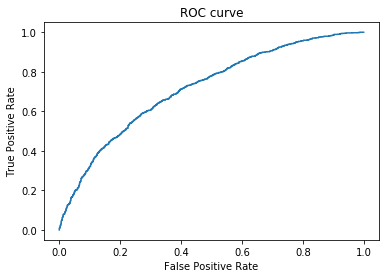

In [107]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val==1, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

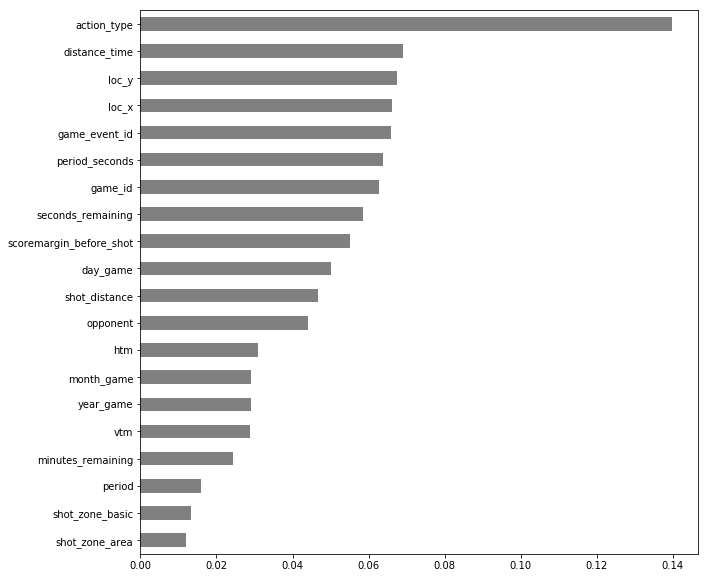

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

rf = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)

importances = pd.Series(rf.feature_importances_, encoded.columns)
n = 20
plt.figure(figsize=(10, 10))
importances.sort_values()[-n:].plot.barh(color='grey')

In [109]:
import eli5
from eli5.sklearn import PermutationImportance

model = pipeline.named_steps['randomforestclassifier']

permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=42
)

encoder = pipeline.named_steps['ordinalencoder']
imputer = pipeline.named_steps['simpleimputer']
X_val_encoded = encoder.transform(X_val)
X_val_processed = imputer.transform(X_val_encoded)

permuter.fit(X_val_processed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.1506 ± 0.0196,action_type
0.0069 ± 0.0000,year_game
0.0035 ± 0.0045,game_id
0.0031 ± 0.0078,loc_x
0.0027 ± 0.0012,opponent
0.0024 ± 0.0041,game_event_id
0.0020 ± 0.0033,shot_zone_range
0.0016 ± 0.0049,day_game
0.0014 ± 0.0045,htm
0.0004 ± 0.0016,minutes_remaining


In [110]:
X_val.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,htm,vtm,season_type,scoremargin_before_shot,year_game,month_game,day_game,home_court,opponent,period_seconds,distance_time
5026,21300788,375,Stephen Curry,3,0,1,Step Back Jump shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,25,0,254,GSW,MIA,Regular Season,-5.0,2014,2,12,True,MIA,1,25
6676,21400999,2,Stephen Curry,1,11,44,Step Back Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,22,99,203,GSW,LAL,Regular Season,0.0,2015,3,16,True,LAL,704,15488
9794,21600405,84,Stephen Curry,1,3,20,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-1,23,GSW,POR,Regular Season,9.0,2016,12,17,True,POR,200,400
5577,41300166,57,Stephen Curry,1,6,5,Driving Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,13,12,GSW,LAC,Playoffs,-7.0,2014,5,1,True,LAC,365,365
9399,21600054,405,Stephen Curry,3,1,11,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,22,102,198,POR,GSW,Regular Season,23.0,2016,11,1,False,POR,71,1562


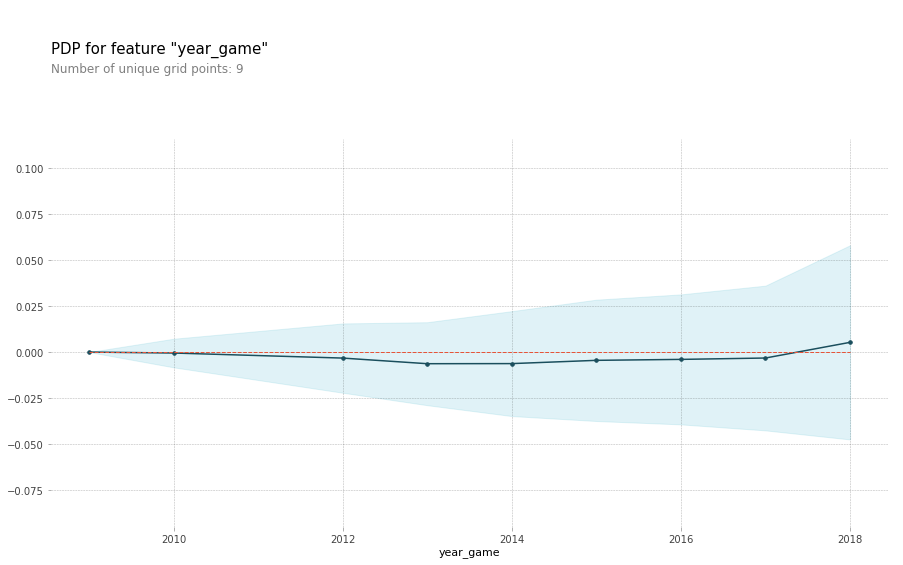

In [111]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'year_game'

isolated = pdp_isolate(
    model = pipeline,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

In [112]:
import shap

row = X_test.iloc[[1]]

explainer = shap.TreeExplainer(model)
row_process = encoder.transform(row)
shap_values = explainer.shap_values(row_process)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0],
    features=row
)

## 7. Get your model's test accuracy

> (One time, at the end.)

In [113]:
# Get test accuracy
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.6348741954359275


In [0]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)
  
# pipeline = make_pipeline (
#   ce.OrdinalEncoder(), 
#   SimpleImputer(strategy='mean'),
#   RandomizedSearchCV(estimator = RandomForestRegressor(),
#                      param_distributions = random_grid,
#                      n_iter = 5,
#                      verbose=2,
#                      random_state=42,
#                      n_jobs = -1)
#   )

# pipeline.fit(X_train, y_train)

# pd.set_option('display.max_rows', 200)
# model = pipeline.named_steps['randomizedsearchcv']
# best = pd.Series(model.best_params_)
# print(best)

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [0]:
# # Calculate accuracy
# Correct_Predictions = 85 + 36
# Total_Predictions = 85 + 58 + 8 + 36

# accuracy = Correct_Predictions / Total_Predictions
# accuracy

### Calculate precision

In [0]:
# # Calculate precision on positives
# Correct_Predictions_Positive = 36
# Total_Predictions_Positive = 36 + 58

# precision = Correct_Predictions_Positive / Total_Predictions_Positive
# precision

In [0]:
# # Calculate precision on negatives
# Correct_Predictions_Negative = 85
# Total_Predictions_Negative = 85 + 8

# precision = Correct_Predictions_Negative / Total_Predictions_Negative
# precision

### Calculate recall

In [0]:
# # Calculate recall on positives
# Actual_Positive = 8 + 36

# recall = Correct_Predictions_Positive / Actual_Positive
# recall

In [0]:
# # Clculate recall on negatives
# Actual_Negative = 85 + 58

# recall = Correct_Predictions_Negative / Actual_Negative
# recall